<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/master/MomentNetwork_demo/bayesian_evidence_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import time

import sys
from scipy.integrate import quad
from scipy.stats import norm
from scipy.integrate import simps
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.layers import concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras import optimizers

import gc

In [157]:
# Generate some synthetic data from the model.
N = 24
x = np.linspace(0,365*2, N)
ystd = 3*np.linspace(2.5,4., N)**2.

In [158]:
def log_prior(theta):
    m, b = theta
    if -0.2 < m < 0.2 and -10. < b < 60.0:
        return -np.log(.4*60.)
    return -np.inf

def log_likelihood(theta, x, y, ystd):
    m, b = theta
    mu = m * x + b
    return -0.5 * (np.sum(((y - mu)/ystd) ** 2.) + len(y) * np.log(np.pi * 2) + np.sum(np.log(ystd**2.)))


def integrate_2d(logz,x,y):
  return simps(simps(np.exp(logz), m_array), b_array)

(Text(0.5, 0, '$X\\ (days) $'), Text(0, 0.5, '$Y\\ (data)$'))

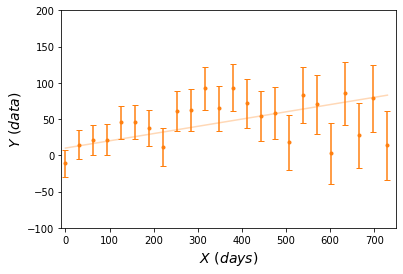

In [159]:
m_true = 0.1
b_true = 10.

y = np.random.normal(m_true * x + b_true, ystd)

plt.plot(x, m_true * x + b_true, c='C1' , alpha=0.3)
plt.errorbar(x, y, yerr=ystd, fmt='.C1', capsize=3.45)
plt.xlim(-9, 750), plt.ylim(-100, 200)
plt.xlabel(r'$X\ (days) $', fontsize=14),plt.ylabel(r'$Y\ (data)$', fontsize=14)

# Calculate brute force

In [160]:
grid_size = 128
m_array = np.linspace(-0.25,.25,grid_size)
b_array = np.linspace(-11.,61.,grid_size)

theta_0, theta_1 = np.array(np.meshgrid(m_array,b_array))
theta_array = np.vstack([theta_0.flatten(), theta_1.flatten()])

In [161]:
prior_array = np.array([log_prior(theta_array[:,i]) \
                         for i in range(theta_array.shape[1])])

likelihood_array = np.array([log_likelihood(theta_array[:,i], x,y,ystd) \
                         for i in range(theta_array.shape[1])])

posterior_array = likelihood_array + prior_array

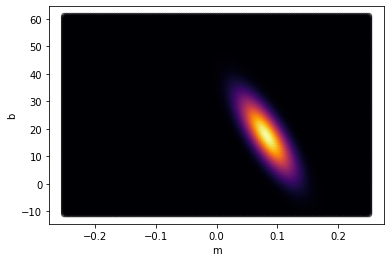

In [162]:
_ = plt.scatter(theta_0, theta_1, c=np.exp(posterior_array), alpha=0.5,cmap='inferno')
_ = plt.xlabel('m'), plt.ylabel('b')

In [163]:
print('prior integral = ')
print(simps(simps(np.exp(np.reshape(prior_array,(grid_size,grid_size))), m_array), b_array))
print('posterior integral = ')
print(simps(simps(np.exp(np.reshape(posterior_array,(grid_size,grid_size))), m_array), b_array))
print(integrate_2d(np.reshape(posterior_array,(grid_size,grid_size)), m_array, b_array))

prior integral = 
1.176266352532705
posterior integral = 
2.649063518660837e-51
2.649063518660837e-51


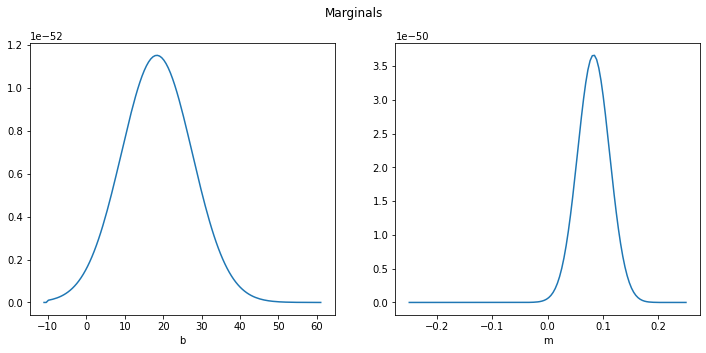

In [164]:
_ = plt.figure(figsize=(12,5)), plt.suptitle('Marginals')
_ = plt.subplot(1,2,1), plt.xlabel('b')
_ = plt.plot(b_array, simps(np.exp(np.reshape(posterior_array,(grid_size,grid_size))), m_array))
_ = plt.subplot(1,2,2), plt.xlabel('m')
_ = plt.plot(m_array, simps(np.exp(np.reshape(posterior_array,(grid_size,grid_size))).T, b_array))

In [165]:
model_1 = integrate_2d(np.reshape(posterior_array,(grid_size,grid_size)), m_array, b_array)
print(model_1)

2.649063518660837e-51


In [166]:
theta_array2 = np.vstack([m_array*0., b_array])

In [167]:
prior_array2 = np.array([log_prior(theta_array2[:,i]) \
                         for i in range(len(b_array))])

likelihood_array2 = np.array([log_likelihood(theta_array2[:,i], x,y,ystd) \
                               for i in range(len(b_array))])

posterior_array2 = likelihood_array2 + prior_array2

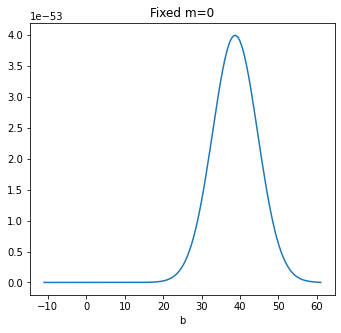

In [168]:
_ = plt.figure(figsize=(12,5)),
_ = plt.subplot(1,2,1), plt.xlabel('b'),  plt.title('Fixed m=0')
_ = plt.plot(b_array, np.exp(posterior_array2))

In [169]:
model_2 = simps(np.exp(posterior_array2), b_array)
print(model_2)

5.868397236864229e-52


In [170]:
bayes_factor = model_1/(model_2)
print(bayes_factor)
print(np.log(bayes_factor))

4.514117589075072
1.50720972791761


In [171]:
model_evidence_calc = model_1/(model_1 + model_2)
print(model_evidence_calc)

0.8186473204740383


# Run evidence net

In [172]:
from tensorflow.keras import callbacks

class simple_leaky:
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, learning_rate=None):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        
    def model(self):
        print(self.input_size)
        
        input_data = (Input(shape=(self.input_size,)))

        x1 = Dense(100, input_dim=self.input_size, kernel_initializer='normal')(input_data)
        x1 = LeakyReLU(alpha=0.1)(x1)
        x2 = Dense(150, kernel_initializer='normal')(x1)
        x2 = LeakyReLU(alpha=0.1)(x2)
        x3 = Dense(100, kernel_initializer='normal')(x2)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x3 = Dense(100, kernel_initializer='normal')(x3)
        x3 = LeakyReLU(alpha=0.1)(x3)
        x4 = Dense(2, kernel_initializer='normal',activation='softmax')(x3)

        dense_model = Model(input_data, x4)

        if self.learning_rate is None:
            dense_model.compile(optimizer='adam', loss='mse')
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate), loss='mse')

        return dense_model

class CustomCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      keys = list(logs.keys())
      print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))

In [173]:
loc_rescale = np.mean(y)
scale_rescale = 20.*ystd

In [174]:
model_instance = simple_leaky(N, learning_rate=2e-5)
regression = model_instance.model()
regression.summary()

24
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 24)]              0         
                                                                 
 dense_225 (Dense)           (None, 100)               2500      
                                                                 
 leaky_re_lu_180 (LeakyReLU)  (None, 100)              0         
                                                                 
 dense_226 (Dense)           (None, 150)               15150     
                                                                 
 leaky_re_lu_181 (LeakyReLU)  (None, 150)              0         
                                                                 
 dense_227 (Dense)           (None, 100)               15100     
                                                                 
 leaky_re_lu_182 (LeakyReLU)  (None, 100)              

Current prior model ratio (model 0/model 1):  1.0107238605898123


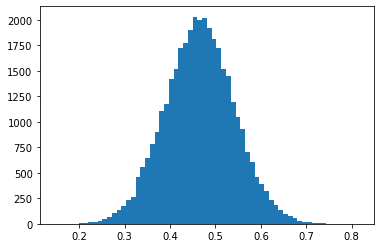

24
22/22 - 0s - loss: 0.1249 - val_loss: 0.1179 - 96ms/epoch - 4ms/step
Network evidence model 0:  0.84317076
Network Bayes factor:  5.3763614
Training prior ratio:  1.0107238605898123
Corrected Bayes factor:  5.319317748122885
Corrected evidence model 0:  0.841755069161217
Next step, more training data from model 1.0
652 1
652 1
Current prior model ratio (model 0/model 1):  0.5393419170243204
24
31/31 - 0s - loss: 0.1050 - val_loss: 0.1235 - 113ms/epoch - 4ms/step
Network evidence model 0:  0.77255815
Network Bayes factor:  3.3967292
Training prior ratio:  0.5393419170243204
Corrected Bayes factor:  6.29791440951097
Corrected evidence model 0:  0.8629745508255406
Next step, more training data from model 1.0
670 1
670 1
Current prior model ratio (model 0/model 1):  0.3646034816247582
24
40/40 - 0s - loss: 0.1013 - val_loss: 0.1013 - 152ms/epoch - 4ms/step
Network evidence model 0:  0.40372163
Network Bayes factor:  0.6770691
Training prior ratio:  0.3646034816247582
Corrected Bayes fac

In [ ]:
n_steps = 100 # number of steps to generate new data
epochs_per_step = 400 # number of network epochs per step
validation_fraction = 0.1 # fraction of validation data
n_sample_init = 1500 # initial number of simulations (samples)

# new model samples fraction compared to optimal number of new samples,
# keep this below 1, as training noise can over predict bayes factor
training_prior_update_epsilon = 0.4


training_m = np.zeros(shape=((0,)))
training_b = np.zeros(shape=((0,)))
training_model = np.zeros(shape=((0,2)))
training_data = np.zeros((0,N), dtype = 'float')
history_loss = np.zeros(shape=((0,)))
history_val_loss = np.zeros(shape=((0,)))
model_flag = None

for step in np.arange(n_steps):

  # Each step, we choose the number of new samples
  if model_flag==0:
      n_sample = (0.5/estimated_model_evidence[0] - 1) * np.sum(training_model[:,1])
      n_sample = int(n_sample*training_prior_update_epsilon)
      print(n_sample, 0)
      training_model_new = np.ones(n_sample)
  elif model_flag==1:
      n_sample = (0.5/estimated_model_evidence[1] - 1) * np.sum(training_model[:,1])
      n_sample = int(n_sample*training_prior_update_epsilon)
      print(n_sample, 1)
      training_model_new = np.zeros(n_sample) 
  else:
    n_sample = n_sample_init
    training_model_new = np.round(np.random.uniform(0,1,n_sample))


  training_m_new = np.random.uniform(-0.2,0.2,n_sample)
  training_b_new = np.random.uniform(-10,60,n_sample)

  training_model_new = np.vstack([training_model_new,
                                  np.abs(1-training_model_new)]).T



  training_m_new = np.where(training_model_new[:,0]>0.5,
                            training_m_new, 0.)

  training_data_new = np.zeros((n_sample,N), dtype = 'float')

  for j in range(n_sample):
      training_data_new[j] =  np.random.normal(training_m_new[j] * x + training_b_new[j],
                                               ystd)
      
  training_m = np.concatenate([training_m, training_m_new])
  training_b = np.concatenate([training_b, training_b_new])
  training_model = np.vstack([training_model, training_model_new])
  training_data = np.vstack([training_data, training_data_new])

  shuffled_indices = np.random.permutation(training_b.shape[0])
  training_m = training_m[shuffled_indices]
  training_b = training_b[shuffled_indices]
  training_model = training_model[shuffled_indices]
  training_data = training_data[shuffled_indices]


  print('Current prior model ratio (model 0/model 1): ',
        np.mean(training_model[:,0])/np.mean(training_model[:,1]),
        flush=True)

  if model_flag == None:
    _ = plt.hist(0.5+((training_data[:]-loc_rescale)/scale_rescale).flatten(),
                 bins=64), plt.show()


  n_training_current = int(training_model.shape[0])
  n_validation = int(validation_fraction*training_model.shape[0])

  regression = model_instance.model()
  initial_weights = regression.get_weights()

  history = regression.fit((0.5+(training_data[:-n_validation]-loc_rescale)/scale_rescale),
                               np.atleast_2d(training_model[:-n_validation]),
                               epochs =epochs_per_step-1,batch_size =64, shuffle=True,
                               validation_data = ((0.5+(training_data[-n_validation:]-loc_rescale)/scale_rescale),
                               np.atleast_2d(training_model[-n_validation:])),
                           verbose=0)
  

  history_loss = np.concatenate([history_loss,
                                 np.array(history.history['loss']).flatten()])
  history_val_loss = np.concatenate([history_val_loss,
                                 np.array(history.history['val_loss']).flatten()])
  
  history = regression.fit((0.5+(training_data[:-n_validation]-loc_rescale)/scale_rescale),
                               np.atleast_2d(training_model[:-n_validation]),
                               epochs =1,batch_size =64, shuffle=True,
                               validation_data = ((0.5+(training_data[-n_validation:]-loc_rescale)/scale_rescale),
                               np.atleast_2d(training_model[-n_validation:])),
                           verbose=2)



  history_loss = np.concatenate([history_loss,
                                 np.array(history.history['loss']).flatten()])
  history_val_loss = np.concatenate([history_val_loss,
                                 np.array(history.history['val_loss']).flatten()])

  estimated_model_evidence = regression.predict(np.atleast_2d(0.5+(y-loc_rescale)/scale_rescale))[0]
  estimated_bayes_factor = estimated_model_evidence[0]/estimated_model_evidence[1]

  prior_ratio = np.mean(training_model[:,0])/np.mean(training_model[:,1])
  
  bayes_factor = estimated_bayes_factor/prior_ratio
  
  if estimated_model_evidence[0] < 0.5:
    model_flag = 0.
  else:
    model_flag = 1.

  print('Network evidence model 0: ', estimated_model_evidence[0])
  print('Network Bayes factor: ', estimated_bayes_factor)
  print('Training prior ratio: ', prior_ratio)
  print('Corrected Bayes factor: ', bayes_factor)
  print('Corrected evidence model 0: ', bayes_factor/(bayes_factor+1))
  print('Next step, more training data from model ' + str(model_flag), flush=True)
  regression.set_weights(initial_weights)
  gc.collect()


In [ ]:
plt.plot(history_loss)
plt.plot(history_val_loss, ':')